In [1]:
import pandas as pd
import matplotlib.pyplot as plt

import numpy as np
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score

import optuna
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C, DotProduct, ExpSineSquared, WhiteKernel, RationalQuadratic

In [2]:
df = pd.read_csv('./ALL_US_monthly_dataset.csv')
df.head()

,time,region,number,spatial_ref,T,LOAD,population,height,T.historical.ukesm1_0_ll,T.historical.mpi_esm1_2_lr,T.historical.hadgem3_gc31_ll,T.historical.ipsl_cm6a_lr,T.ssp126.hadgem3_gc31_ll,T.ssp126.mpi_esm1_2_lr,T.ssp126.ipsl_cm6a_lr,T.ssp126.ukesm1_0_ll,T.ssp585.ipsl_cm6a_lr,T.ssp585.ukesm1_0_ll,T.ssp585.hadgem3_gc31_ll,T.ssp585.mpi_esm1_2_lr
0,1990-12-31,ALL_US,0,0,272.20386,2.886496e+06,2.464447e+08,1.5,270.327969,272.669663,273.341923,271.635486,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1991-01-31,ALL_US,0,0,271.37045,2.894741e+06,2.466815e+08,1.5,271.193351,272.579198,267.469103,270.020157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1991-02-28,ALL_US,0,0,277.24652,2.901620e+06,2.469048e+08,1.5,271.351362,272.378916,270.389448,270.545610,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1991-03-31,ALL_US,0,0,279.30440,2.908608e+06,2.471624e+08,1.5,275.229272,274.810128,278.155739,276.119287,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1991-04-30,ALL_US,0,0,284.57156,2.914741e+06,2.474220e+08,1.5,282.443010,281.621323,284.251871,282.228042,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
# Assuming your DataFrame is already loaded as df
# Ensure 'time' is datetime
df['time'] = pd.to_datetime(df['time'])
df = df.sort_values('time')

# Define features and target
X = df[['T', 'population']].values
y = df['LOAD'].values

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split into train and test sets (e.g., last 20% for test)
split_index = int(len(df) * 0.7)

train_start_ind = int(len(df) * 0)
train_end_ind = int(len(df) * 0.6)

test_start_ind = int(len(df) * 0.6)
test_end_ind = int(len(df) * 0.9)

X_train, X_test = X_scaled[train_start_ind:train_end_ind], X_scaled[test_start_ind:test_end_ind]
y_train, y_test = y[train_start_ind:train_end_ind], y[test_start_ind:test_end_ind]
time_train = df['time'].iloc[train_start_ind:train_end_ind]
time_test = df['time'].iloc[test_start_ind:test_end_ind]

In [4]:
%%capture

def objective(trial):
    # Sample hyperparameters
    
    rbf_length_scale = trial.suggest_loguniform("rbf_length_scale", 1e-2, 1e2)
    
    sigma_0 = trial.suggest_loguniform("sigma_0", 1e-2, 1e2)
    periodicity = trial.suggest_uniform("periodicity", 6, 365)  # seasonal range
    periodic_l_scale = trial.suggest_loguniform("periodic_l_scale", 1e-2, 1e2)

    quad_length_scale = trial.suggest_loguniform("quad_length_scale", 1e-2, 1e2)
    quad_alpha = trial.suggest_loguniform("quad_alpha", 1e-2, 1e2)
    
    noise_level = trial.suggest_loguniform("noise_level", 1e-5, 1e1)

    # Build kernel with sampled hyperparameters
    kernel = (
        C(1.0, (1e-2, 1e2)) *
        (
            # RBF(length_scale=rbf_length_scale) +
            RationalQuadratic(length_scale=quad_length_scale, alpha=quad_alpha) + 
            DotProduct(sigma_0=sigma_0) 
            #ExpSineSquared(length_scale=periodic_l_scale, periodicity=periodicity) 
        ) +
        WhiteKernel(noise_level=noise_level)
    )

    # Fit model
    gpr = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=5, normalize_y=True)
    gpr.fit(X_train, y_train)
    y_pred = gpr.predict(X_test)

    # Objective: maximize R² score (or minimize MSE if you prefer)
    score = r2_score(y_test, y_pred)
    #return score
    return -mean_squared_error(y_test, y_pred)

# Create and run study
study = optuna.create_study(direction="maximize")  # or direction="minimize" for MSE
study.optimize(objective, n_trials=30)  # adjust n_trials as needed

[I 2025-05-06 19:11:27,150] A new study created in memory with name: no-name-132ae073-43ac-44a4-b4c9-f6fa0eb75f77
[I 2025-05-06 19:11:27,917] Trial 0 finished with value: -1764611642.1272974 and parameters: {'rbf_length_scale': 0.06944603410912589, 'sigma_0': 0.02447323558671377, 'periodicity': 336.4130622381159, 'periodic_l_scale': 2.329894991773903, 'quad_length_scale': 0.5311282633153854, 'quad_alpha': 1.274212222887759, 'noise_level': 6.904367353461295e-05}. Best is trial 0 with value: -1764611642.1272974.
[I 2025-05-06 19:11:29,511] Trial 1 finished with value: -1764576697.9420562 and parameters: {'rbf_length_scale': 62.36527923885871, 'sigma_0': 0.053838759307762815, 'periodicity': 79.23535663174192, 'periodic_l_scale': 15.923991012221789, 'quad_length_scale': 51.47895089897476, 'quad_alpha': 15.841646457432704, 'noise_level': 0.0005040760897976857}. Best is trial 1 with value: -1764576697.9420562.
[I 2025-05-06 19:11:30,547] Trial 2 finished with value: -1764619629.1483872 and p

In [5]:
# Best result
print("\nBest R² Score:", study.best_value)
print("Best hyperparameters:", study.best_params)

best = study.best_params

final_kernel = (
    C(1.0, (1e-2, 1e2)) *
    (
     # RBF(length_scale=best["rbf_length_scale"]) +
     RationalQuadratic(length_scale=best["quad_length_scale"], alpha=best["quad_alpha"]) +
     DotProduct(sigma_0=best["sigma_0"]) 
     # ExpSineSquared(length_scale=best["periodic_l_scale"], periodicity=best["periodicity"])
    ) +
    WhiteKernel(noise_level=best["noise_level"])
)

gpr = GaussianProcessRegressor(kernel=final_kernel, n_restarts_optimizer=10, normalize_y=True)

# Fit the model
gpr.fit(X_train, y_train)


Best R² Score: -1764300180.5970812
Best hyperparameters: {'rbf_length_scale': 98.7466116039154, 'sigma_0': 5.932973009893285, 'periodicity': 6.437136036007644, 'periodic_l_scale': 0.1377974826553614, 'quad_length_scale': 8.473445802865042, 'quad_alpha': 0.011432877112590325, 'noise_level': 0.04858478880186968}


GaussianProcessRegressor(kernel=1**2 * RationalQuadratic(alpha=0.0114, length_scale=8.47) + DotProduct(sigma_0=5.93) + WhiteKernel(noise_level=0.0486),
                         n_restarts_optimizer=10, normalize_y=True)

R2 Score: 0.8246709456194089
MSE: 1764592319.5953746


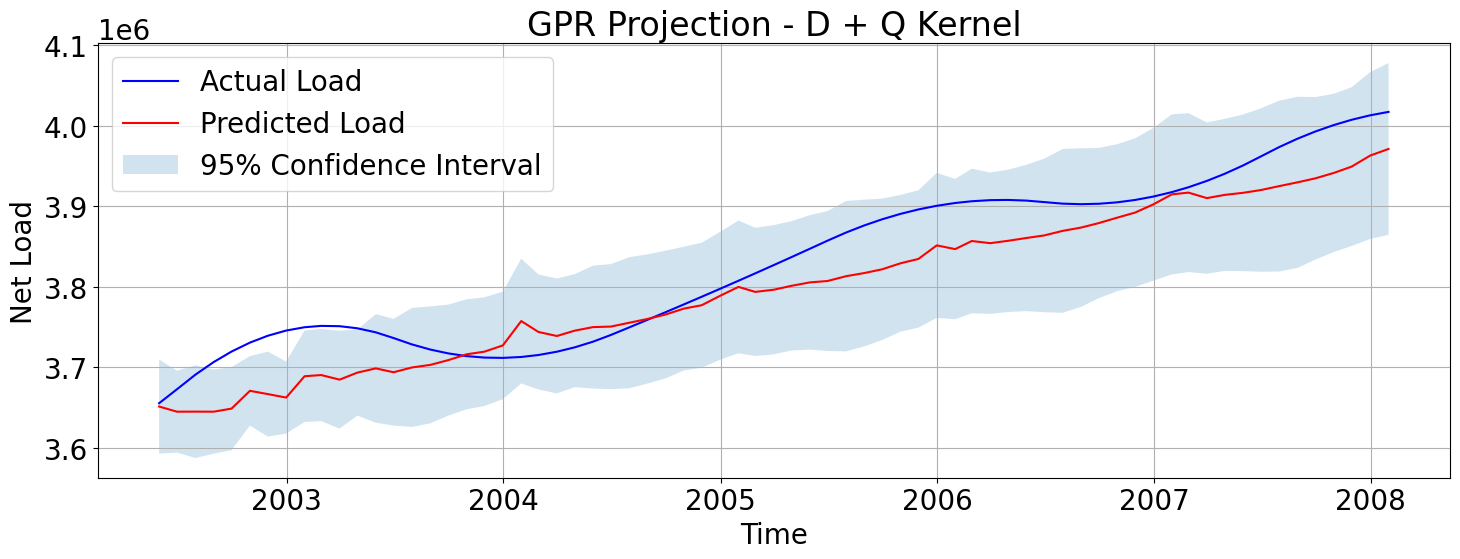

In [6]:
# Predict
y_pred, sigma = gpr.predict(X_test, return_std=True)

# Evaluate
print("R2 Score:", r2_score(y_test, y_pred))
print("MSE:", mean_squared_error(y_test, y_pred))

plt.rcParams.update({'font.size': 20})

# Plot results
plt.figure(figsize=(15, 6))
plt.plot(time_test, y_test, 'b-', label='Actual Load')
plt.plot(time_test, y_pred, 'r-', label='Predicted Load')
plt.fill_between(time_test, y_pred - 1.96*sigma, y_pred + 1.96*sigma, alpha=0.2, label='95% Confidence Interval')
plt.title("GPR Projection - D + Q Kernel")
plt.xlabel("Time")
plt.ylabel("Net Load")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("gpr_test_prediction.png", dpi=300, bbox_inches='tight')
plt.show()

R2 Score: 0.9947048612135306
MSE: 591217200.109768


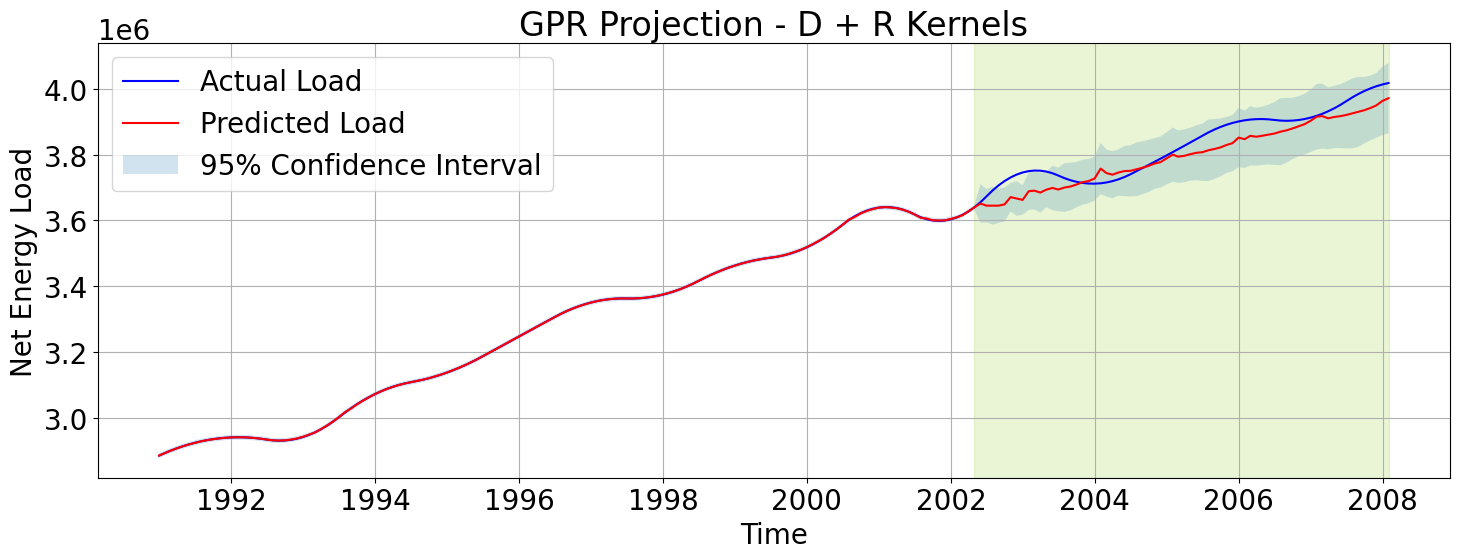

In [7]:
time_total = df['time'].iloc[train_start_ind:test_end_ind]
y_total = y[train_start_ind:test_end_ind]

# Predict
y_pred_total, sigma = gpr.predict(X_scaled[train_start_ind:test_end_ind], return_std=True)

# Evaluate
print("R2 Score:", r2_score(y_total, y_pred_total))
print("MSE:", mean_squared_error(y_total, y_pred_total))

# Plot results
plt.figure(figsize=(15, 6))
plt.plot(time_total, y_total, 'b-', label='Actual Load')
plt.plot(time_total, y_pred_total, 'r-', label='Predicted Load')

n_tps = len(time_total)
n_test_tps = test_end_ind - test_start_ind
plt.axvspan(time_total[n_tps - (1+ n_test_tps)], time_total[n_tps - 1], color='yellowgreen', alpha=0.2)

plt.fill_between(time_total, y_pred_total - 1.96*sigma, y_pred_total + 1.96*sigma, alpha=0.2, label='95% Confidence Interval')

plt.title("GPR Projection - D + R Kernels")
plt.xlabel("Time")
plt.ylabel("Net Energy Load")
plt.legend()
plt.grid(True)
plt.tight_layout()

plt.savefig("gpr_complete_prediction.png", dpi=300, bbox_inches='tight')
plt.show()